## 환경 구축

> conda create -n test_env python=3.8.10 

> pip install -r requirements.txt

## 라이브러리 import

In [2]:
from tqdm import tqdm 
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import matplotlib.pyplot as plt

### 제공된 Baseline 코드

In [5]:
def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

## EDA

### Tick 데이터 가공
 
단순히 tick->ohlcv로 가공이 아닌, 시장미시구조 적인 feature를 새로 만듭니다.


tick데이터의 핵심적인 정보인 order flow를 Tick rule 기반으로 판단합니다. 

tick rule이란,
- 현재 체결가격 > 이전 체결가격 => Buy
- 현재 체결가격 < 이전 체결가격 => Sell
- 현재 체결가격 = 이전 체결가격 => 이전 주문흐름과 같음
로 구성됩니다. 

maker to maker 거래를 포착하기 위해서 
- Buy 매수가 이전 매수 시장가보다 2,3틱 높으면 체크합니다.
- Sell 매수가 이전 매도 시장가보다 2,3틱 높으면 체크합니다.

maker to maker 거래는 정보기반 trader를 포착할 수 있다고 생각했습니다.

--------------------
#### calc_order_flow
Tick rule을 기반으로 주문 흐름을 판단하는 코드입니다. 


In [6]:
def calc_order_flow(df):
    df_copy = df.copy()
    
    # 카피한 데이터에 column을 초기화니다.
    df_copy["buy"] = False
    df_copy["sell"] = False
    df_copy["2tick_buy"] = False
    df_copy["2tick_sell"] = False
    df_copy["2+tick_buy"] = False
    df_copy["2+tick_sell"] = False

    previous_execute_price = -1    # 직전 체결가를 -1로 초기화 합니다.

    previous_order_flow = 1    # 직전 주문흐름을 buy로 초기화합니다.
    
    execute_prices = df_copy["price"].values # row by row로 계산이 진행되기 때문에 필요한 코드입니다. 
    
    for i in tqdm(range(1, len(df_copy))):
        execute_price = execute_prices[i]


        if previous_execute_price < 0:
            previous_execute_price = execute_price

        if execute_price > previous_execute_price:
            df_copy.at[i, 'buy'] = True
            previous_order_flow = 1

            if execute_price == previous_execute_price + 0.2:
                df_copy.at[i, "2tick_buy"] = df_copy.at[i, 'qty']
            if execute_price > previous_execute_price + 0.2:
                df_copy.at[i, "2+tick_buy"] = df_copy.at[i, 'qty']

        elif execute_price < previous_execute_price:
            df_copy.at[i, 'sell'] = True
            previous_order_flow = -1

            if execute_price == previous_execute_price - 0.2:
                df_copy.at[i, "2tick_sell"] = df_copy.at[i, 'qty']
            if execute_price < previous_execute_price - 0.2:
                df_copy.at[i, "2+tick_sell"] = df_copy.at[i, 'qty']

        elif execute_price == previous_execute_price:
            if previous_order_flow == 1:
                df_copy.at[i, 'buy'] = True
            elif previous_order_flow == -1:
                df_copy.at[i, 'sell'] = True

        previous_execute_price = execute_price

    return df_copy

tick rule을 기반으로 판단한 주문흐름으로 부터 VPIN을 추정합니다. <br>
VPIN을 통해서 시장의 정보기반 거래자를 추적할 수 있습니다. <br>

VPIN의 bucket size와 bucket의 개수는 저희가 임의로 설정했습니다. <br>
저희는 bucket size와 bucket의 개수를 변화하면서 두개의 VPIN을 추정했습니다. 

> bucket_size: 54, bucket_num:5

위 파라미터를 기반으로 짧은 시간(대락 10분)의 vpin을 추정합니다. 
 
> bucket_size: 1000, bucket_num:3

위 파라미터를 기반으로 긴 시간(대락 3시간)의 vpin을 추정합니다. 

#### calc_vpin_bucket
tick rule을 통해 계산한 주문흐름으로 vpin을 계산하는 코드입니다. 
이 함수로 vpin의 bucket을 생성하고 주문을 bucket에 채웁니다.

In [7]:
# vpin을 계산하는 코드입니다. 
# 이 함수로 vpin의 bucket을 생성하고 주문을 bucket에 채웁니다.
def calc_vpin_bucket(df_order_flow, BUCKET_SIZE=54, N=5):
    bucket_list = []
    BUCKET_INDEX = 0
    eps = 1e-05

    for index, row in tqdm(enumerate(df_order_flow.itertuples(), start=1)):
        try:
            element = bucket_list[BUCKET_INDEX]
        except IndexError: # 버켓이 꽉차서 다음 버켓으로 넘어갈 때 예외처리를 했습니다. 
            # 버켓은 (buy_qty, sell_qty, 버켓에 채워진 거래량, 버켓에 남은 거래량, 버켓 index)로 구성됩니다.
            bucket_list.extend([np.array([0, 0, 0, BUCKET_SIZE, index], dtype=np.float32)]) 
            element = bucket_list[BUCKET_INDEX]

        qty = row.qty
        buy = row.buy
        sell = row.sell
        bucket_temp = element[3]

        buy_qty = qty if buy else 0
        sell_qty = qty if sell else 0

        elem_list = np.array([buy_qty, sell_qty, qty, -qty, 1], dtype=np.float32)
        element += elem_list

        next_bucket_elem = qty - bucket_temp

        if next_bucket_elem > 0:
            element[:3] -= [buy * next_bucket_elem, sell * next_bucket_elem, next_bucket_elem]
            element[3] += next_bucket_elem

            new_bucket_elem = np.array([max(buy_qty - bucket_temp, 0), 
                                        max(sell_qty - bucket_temp, 0), 
                                        next_bucket_elem, 
                                        BUCKET_SIZE - next_bucket_elem, 
                                        index], dtype=np.float32)

            bucket_list.extend([new_bucket_elem])
            BUCKET_INDEX += 1

    return np.array(bucket_list)

#### calc_VPIN
생성된 bucket들을 기반으로 vpin값을 계산합니다. 


In [8]:
# 생성된 bucket들을 기반으로 vpin값을 계산합니다. 
def calc_VPIN(bucket_list, BUCKET_SIZE, N):
    eps = 1e-05
    return_list  = [] 
    order_imbalance_list= []
    for elem in bucket_list:
        order_imbalance = abs(elem[0]-elem[1])
        order_imbalance_list.append(order_imbalance)
    
    for i in range(N-1, len(bucket_list)):
        if bucket_list[i][3] < eps:
            return_list.append(sum(order_imbalance_list[i-N+1:i]) / (BUCKET_SIZE*N))
            
    return return_list

#### tick2vpin
위에 작성한 함수들을 합쳐서 한개의 함수만을 사용하면 됩니다.


In [9]:
# 위에 작성한 함수들을 합쳐서 한개의 함수만을 사용하면 됩니다.
def tick2vpin(df, BUCKET_SIZE=54, N=5):
    df_order_flow  = calc_order_flow(df)
    bucket_list = calc_vpin_bucket(df_order_flow, BUCKET_SIZE=BUCKET_SIZE, N=5)
    vpin = calc_VPIN(bucket_list, BUCKET_SIZE, N=5)

    df_order_flow["vpin"] = 0

    start_index = 0
    for i in range(len(vpin)):
        end_index = int(bucket_list[i][4])
        vpin_loc = df_order_flow.columns.get_loc("vpin")
        df_order_flow.iloc[start_index:end_index, vpin_loc] = vpin[i]
        start_index = end_index
        
    return df_order_flow, bucket_list, vpin

In [10]:
# 위 작성한 함수를 기반으로 
# tick데이터로부터 더 다양한 데이터가 담긴 ohlcv데이터를 생성합니다. 
def tick2ohlcv_orderflow(data, BUCKET_SIZE, N):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """
    df_order_flow, bucket_list, vpin = tick2vpin(data, BUCKET_SIZE, N)
    df_order_flow['inter_trade_duration'] = (df_order_flow['time']//1000).diff()
    
    df_order_flow['time'] = pd.to_datetime(df_order_flow['time'], unit='ms')
    df_order_flow['weighted_vpin_15'] = df_order_flow['vpin'].copy()
     
    ohlcv = df_order_flow.resample('1h', on='time').agg({
        'inter_trade_duration': ['mean', 'std', 'skew'],            # 주문의 간격에 관한 데이터 입니다.
        'price': ['first', 'max', 'min', 'last', 'std', 'skew'],    # 가격에 대한 데이터 입니다.
        'qty': ['sum', 'std', 'skew'],                              # 거래량에 대한 데이터 입니다.
        '2tick_buy': 'sum', '2tick_sell': 'sum',                    # 현재 시장가보다 비싸게/싸게 산 거래량입니다.
        '2+tick_buy' : 'sum',"2+tick_sell" :'sum',                  # 현재 시장가보다 비싸게/싸게 산 거래량입니다.
        'vpin': 'mean',                                             # vpin입니다
        'id' : 'count'                                              # 거래 체결 횟수입니다.
})

    ohlcv.columns = ['itd_maen', 'itd_std', 'itd_skew', 
                    'Open', 'High', 'Low', 'Close', 'Std', 'Skew',
                    'Volume', "Volume_std", 'Volume_skew',
                    '2tick_buy_ratio', '2tick_sell_ratio', 
                    '2+tick_buy_ratio', '2+tick_sell_ratio',
                    'vpin',
                    'num']
    

    ohlcv.loc[ohlcv[ohlcv["Volume"]==0].index, 'Volume'] = np.inf

    ohlcv['2tick_buy_ratio'] /= ohlcv['Volume']
    ohlcv['2tick_sell_ratio'] /= ohlcv['Volume']
    ohlcv['2+tick_buy_ratio'] /= ohlcv['Volume']
    ohlcv['2+tick_sell_ratio'] /= ohlcv['Volume']
    
    return ohlcv 

### OHLCV 데이터 전처리

위에서 만들어진 1시간봉을 기반으로 feature를 더 생성합니다.

생성하는 Feature들은 아래와 같습니다. 
<br>
<br>
- 다양한 기술적 지표 
   - wap, vwap, macd_line, signal_line, moving_average, midas, obv, upper_band, lower_band, rsi, mfi, iliquidity_ratio
<br>
- 이전 time step의 데이터 
  - log_mean_1h, log_variance_1h, close_diff, returns_1, returns_2, returns_3, returns_4, returns_5, volatility_20h
  - 다른 기술적 지표들의 변화량
  - 변동성의 moving_average

#### ohlcv2EDA
OHLCV를 기반으로 기술적 지표와 이전 time step 데이터를 생성하는 코드


In [11]:
# OHLCV를 기반으로 기술적 지표와 이전 time step 데이터를 생성하는 코드
def ohlcv2EDA(ohlcv):
    # Extracting individual components
    open_prices = ohlcv['Open'].values
    high_prices = ohlcv['High'].values
    low_prices = ohlcv['Low'].values
    close_prices = ohlcv['Close'].values
    volumes = ohlcv['Volume'].values

    # Weighted Average Price (WAP)
    wap = (high_prices + low_prices + close_prices) / 3.0

    # Volume Weighted Average Price (VWAP)
    cum_volume = np.cumsum(volumes)
    cum_wap_volume = np.cumsum(wap * volumes)
    vwap = cum_wap_volume / cum_volume

    # Moving Average (MA)
    ma = np.mean(close_prices)

    # Moving Average Convergence Divergence (MACD)
    short_term_ema = pd.Series(close_prices).ewm(span=12, adjust=False).mean().values
    long_term_ema = pd.Series(close_prices).ewm(span=26, adjust=False).mean().values
    macd_line = short_term_ema - long_term_ema
    signal_line = pd.Series(macd_line).ewm(span=9, adjust=False).mean().values

    # MIDAS (Market Interpretation/Data Analysis System)
    midas = (2 * close_prices + high_prices + low_prices) / 4

    # On-Balance Volume (OBV)
    obv = np.where(close_prices > np.roll(close_prices, 1), volumes, 
                   np.where(close_prices < np.roll(close_prices, 1), -volumes, 0)).cumsum()

    # Bollinger Bands
    sma = pd.Series(close_prices).rolling(window=20).mean().values
    rolling_std = pd.Series(close_prices).rolling(window=20).std().values
    upper_band = sma + (2 * rolling_std)
    lower_band = sma - (2 * rolling_std)

    # Relative Strength Index (RSI)
    delta = np.diff(close_prices)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = np.mean(gain[:14])
    avg_loss = np.mean(loss[:14])
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Money Flow Index (MFI)
    typical_price = (high_prices + low_prices + close_prices) / 3
    raw_money_flow = typical_price * volumes
    positive_money_flow = np.where(typical_price > np.roll(typical_price, 1), raw_money_flow, 0)
    negative_money_flow = np.where(typical_price < np.roll(typical_price, 1), -raw_money_flow, 0)
    pos_mf_ratio = np.sum(positive_money_flow[:14]) / np.sum(negative_money_flow[:14])
    mfi = 100 - (100 / (1 + pos_mf_ratio))
    
    # Iliquidity Ratio
    iliquidity_ratio = ohlcv['Close'].pct_change() / ohlcv['Volume']
    
    # Log 스케일로 데이터 변환
    log_returns = np.log(ohlcv['Close'] / ohlcv['Close'].shift(1))


    # Log 스케일로 데이터 변환 후의 지표 계산
    log_mean_1h = log_returns.mean()
    log_variance_1h = log_returns.var()
    log_median_1h = log_returns.median()

    # 이전 STEP에서의 변화량
    close_diff = ohlcv['Close'].diff()

    # 이전 시간동안의 return
    returns_1 = ohlcv['Close'].shift(0) / ohlcv['Close'].shift(1) - 1
    returns_2 = ohlcv['Close'].shift(1) / ohlcv['Close'].shift(2) - 1
    returns_3 = ohlcv['Close'].shift(2) / ohlcv['Close'].shift(3) - 1
    returns_4 = ohlcv['Close'].shift(3) / ohlcv['Close'].shift(4) - 1
    returns_5 = ohlcv['Close'].shift(4) / ohlcv['Close'].shift(5) - 1
    
    # 이전 20시간 동안의 변동성 계산
    volatility_20h = returns_1.rolling(window=20).std()

    
    final_df = pd.DataFrame({
        'wap': wap,
        'vwap': vwap,
        'macd_line': macd_line,
        'signal_line': signal_line,
        'ma': ma,
        'midas': midas,
        'obv': obv,
        'upper_band': upper_band,
        'lower_band': lower_band,
        'rsi': rsi,
        'mfi': mfi,
        'iliquidity_ratio': iliquidity_ratio,
        'log_mean_1h': log_mean_1h,
        'log_variance_1h': log_variance_1h,
        'close_diff': close_diff,
        'returns_1': returns_1,
        'returns_2': returns_2,
        'returns_3': returns_3,
        'returns_4': returns_4,
        'returns_5': returns_5,
        'volatility_20h': volatility_20h
        })
    
    final_df.fillna(final_df.mean(), inplace=True)
    
    final_df = pd.concat([ohlcv, final_df], axis=1) 
    return final_df

#### make_final_eda_data
논문에서 발췌한 feature와 추가적인 전처리를 통해 최종적인 데이터를 생성하는 코드입니다.

- 논문에서 참고한 데이터
- 기술적지표들과 기존에 가공된 데이터들의 변화량/분산/이동평균 등
을 다양하게 포함했습니다.


참고한 논문입니다.
  - Forecasting of Realised Volatility with the Random Forests Algorithm

In [12]:
# 논문에서 발췌한 feature와 추가적인 전처리를 통해 최종적인 데이터를 생성하는 코드 
def make_final_eda_data(data):
    data_index = data.index
    data = data.reset_index()

    data['TR'] = 0  # Initialize TR column

    for index, row in data.iterrows():
        if index > 0:
            data.at[index, 'TR'] = max(row['High'] - row['Low'], abs(row['High'] - row['Close']), abs(row['Low'] - data.at[index-1, 'Close']))

    # Calculate ATR
    n = 14  # You can adjust the period 'n'
    data['ATR'] = data['TR'].rolling(window=n).mean()
    # Calculate ATR
    n = 14  # You can adjust the period 'n'
    data['ATR'] = data['TR'].rolling(window=n).mean()


    # Calculate CRTDR
    data['CRTDR'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])


    # Calculate EMARV
    n = 14  # You can adjust the period 'n'
    kappa = 2 / (n + 1)
    data['EMARV'] = data['ATR'] - kappa * data['ATR'].ewm(span=n).mean() + (1 - kappa) * data['ATR'].ewm(span=n).mean()

    # Calculate MACD
    m = 26  # You can adjust the period 'm'
    n = 12  # You can adjust the period 'n'
    data['MACDRV'] = data['EMARV'].ewm(span=m).mean() - data['EMARV'].ewm(span=n).mean()
    # Assuming data is your DataFrame
    # Make sure 'High', 'Low', and 'Close' columns exist

    # Calculate RV+ and RV- using iterrows
    n = 14  # You can adjust the period 'n'
    data['RV+'] = 0  # Initialize RV+ column
    data['RV-'] = 0  # Initialize RV- column

    for index, row in data.iterrows():
        if index > 0:
            price_diff = row['Close'] - data.at[index-1, 'Close']
            if price_diff > 0:
                data.at[index, 'RV+'] = price_diff
            elif price_diff < 0:
                data.at[index, 'RV-'] = abs(price_diff)

    # Calculate RSIRV
    data['RSIRV'] = 1 - 1 / (1 + data['RV+'].rolling(window=n).mean() / data['RV-'].rolling(window=n).mean())
    
    moving_avg_periods = [3, 6, 9, 12, 15, 18, 24, 48, 72]

    data['Returns'] = data['Close'].pct_change()
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Volatility'] = data['Returns'].rolling(window=20).std()

    for period in moving_avg_periods:
        data[f'MA_{period}_Returns'] = data['Returns'].rolling(window=period).mean()
        data[f'MA_{period}_Log_Returns'] = data['Log_Returns'].rolling(window=period).mean()
        data[f'MA_{period}_Volatility'] = data['Volatility'].rolling(window=period).mean()

        data[f'Diff_MA_{period}_Returns'] = data[f'MA_{period}_Returns'].diff()
        data[f'Diff_MA_{period}_Log_Returns'] = data[f'MA_{period}_Log_Returns'].diff()
        data[f'Diff_MA_{period}_Volatility'] = data[f'MA_{period}_Volatility'].diff()

    data['3_ma'] = data['Close'].rolling(window=3).mean()
    data['6_ma'] = data['Close'].rolling(window=6).mean()
    data['12_ma'] = data['Close'].rolling(window=12).mean()
    data['24_ma'] = data['Close'].rolling(window=24).mean()
    data['48_ma'] = data['Close'].rolling(window=48).mean()
    data['72_ma'] = data['Close'].rolling(window=72).mean()

    value_col = ['Open', 'High', 'Low', 'Close', 'num', 'wap', 'vwap', 'midas', 
             'obv', 'upper_band', 'lower_band', 'mfi', '3_ma', '6_ma',
             '12_ma', '24_ma', '48_ma', '72_ma']
    
    value_log_diff_col = [col+'_log_diff' for col in value_col]
    data[value_log_diff_col] = np.log(data[value_col]).diff()

    data = data.fillna(method='ffill')
    data = data.fillna(method='bfill')
    
    data = data.replace([np.inf, -np.inf], 0)
    
    return data

## 데이터 불러오기/코드실행

In [ ]:
import os
import pickle

# Define the directory name
directory_name_long = 'tick_data_long'
directory_name_short = 'tick_data_short'

# Define the directory name
eda_directory_name_long = 'EDA_data_long'
eda_directory_name_short = 'EDA_data_short'

# Define the directory name
final_eda_directory_name = "final_eda_data"

if not os.path.exists(directory_name_long):
    os.makedirs(directory_name_long)

if not os.path.exists(directory_name_short):
    os.makedirs(directory_name_short)

if not os.path.exists(eda_directory_name_long):
    os.makedirs(eda_directory_name_long)

if not os.path.exists(eda_directory_name_short):
    os.makedirs(eda_directory_name_short)
    
if not os.path.exists(final_eda_directory_name):
    os.makedirs(final_eda_directory_name)


# 저희가 마지막으로 받은 1월 데이터로 실습 환경을 구성했습니다
# 즉, 일별 비트코인 틱 데이터가 입력될거라고 생각하고 만들었습니다.
for month in range(1, 3):
    file_month =  str(month).zfill(2)
    print(file_month)
    
    file_path = r'C:\Users\user\Desktop\ASCEND_test_env\test_dataset\BTCUSDT-trades-2024-01-{}.zip'.format(file_month)

    df_og = pd.read_csv(file_path)
    # tick 데이터를 시간순으로 정렬
    df_og = df_og.sort_values(by="time")

    # 우선 tick데이터를 ohlcv로 가공합니다. 
    # 비효율적이긴 하지만 VPIN의 Bucket size 다르게 계산하기 위해서 같은 코드를 두번 실행합니다.
    df_order_flow_long = tick2ohlcv_orderflow(df_og, BUCKET_SIZE=54, N=5) # 3시간 정도의 VPIN을 계산 
    df_order_flow_short = tick2ohlcv_orderflow(df_og, BUCKET_SIZE=2500, N=5) # 하루정도의 VPIN을 계산

    # ohlcv로 가공한 코드를  전처리 합니다. 
    ohlcv_long = ohlcv2EDA(df_order_flow_long)
    ohlcv_short = ohlcv2EDA(df_order_flow_short)

    # vpin의 기간이 다른 두개의 데이터 프레임을 합치는 과정입니다.
    # 이때 vpin을 제외한 컬럼은 같기 때문에 나머지 컬럼들은 유지하고
    # vpin 컬럼만 합쳐서 새로운 하나의 데이터 프레임으로 생성합니다.  
    eda_data = ohlcv_long[['Open', 'High', 'Low', 'Close', 'Std', 'Skew', 'Volume', 'Volume_std',
       'Volume_skew', '2tick_buy_ratio', '2tick_sell_ratio',
       '2+tick_buy_ratio', '2+tick_sell_ratio', 'num', 'wap', 'vwap',
       'macd_line', 'signal_line', 'ma', 'midas', 'obv', 'upper_band',
       'lower_band', 'rsi', 'mfi', 'iliquidity_ratio', 'log_mean_1h',
       'log_variance_1h', 'close_diff', 'returns_1', 'returns_2', 'returns_3',
       'returns_4', 'returns_5', 'volatility_20h']]

    long_interval_vpin = ohlcv_long["vpin"]
    long_interval_vpin.name = 'long_interval_vpin'

    short_interval_vpin = ohlcv_short["vpin"]
    short_interval_vpin.name = 'short_interval_vpin'
    
    eda_df = pd.concat([eda_data, short_interval_vpin, long_interval_vpin], axis=1)
    
    # 하나로 합쳐진 데이터를 최종적으로 전처리합니다.
    # 이는 학습에 사용될 데이터 입니다.
    final_eda_df = make_final_eda_data(eda_df)


    out_file_name_long = '{}/eda_tick_data_{}.pkl'.format(directory_name_long, file_month)
    out_file_name_short = '{}/eda_tick_data_{}.pkl'.format(directory_name_short, file_month)
    eda_out_file_name_long = '{}/eda_data_{}.pkl'.format(eda_directory_name_long, file_month)
    eda_out_file_name_short = '{}/eda_data_{}.pkl'.format(eda_directory_name_short, file_month)
    final_eda_out_file_name = '{}/final_eda_data_{}.pkl'.format(final_eda_directory_name, file_month)
    
    with open(out_file_name_long, 'wb') as f:
        pickle.dump(df_order_flow_long, f)

    with open(out_file_name_short, 'wb') as f:
        pickle.dump(df_order_flow_short, f)

    with open(eda_out_file_name_long, 'wb') as f:
        pickle.dump(ohlcv_long, f)

    with open(eda_out_file_name_short, 'wb') as f:
        pickle.dump(ohlcv_short, f)
    
    with open(final_eda_out_file_name, 'wb') as f:
        pickle.dump(final_eda_df, f)
    

## 가공 데이터 합치기
final_eda 데이터를 만들긴 했지만, 이는 분리되어 있는 데이터 입니다.

이 데이터를 하나로 합치는 과정입니다. 

In [17]:
final_dict = {}

for month in range(1, 3):
    month = str(month).zfill(2)
    file_path = "C:/Users/user/Desktop/ASCEND_test_env/final_eda_data/final_eda_data_{}.pkl".format(month) 
    
    with open(file_path, 'rb') as f:
        final_dict[month] = pickle.load(f)

final_df = pd.DataFrame()
for month in range(1, 3):
    month = str(month).zfill(2)
    month_df = final_dict[month]
    final_df = pd.concat([final_df, month_df])

In [48]:
final_df = pd.read_csv('/Users/sonhyeongjin/Desktop/project/assend/data/final_df (1).csv',index_col=0)

In [49]:
final_df = final_df.fillna(method='ffill').fillna(method='bfill')
final_df = final_df.replace([np.inf, -np.inf], 0)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/288907382.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df = final_df.fillna(method='ffill').fillna(method='bfill')


## 학습 단계
저희는 마지막 73시간의 데이터를 사용해서 예측해야합니다.

마지막 73시간을 예측하는 모델을 학습할 때 직전의 모든 데이터를 학습하지 않습니다. 

저희가 휴리스틱하게 설정한 적정한 길이를 학습합니다. 
- 대략적으로 학습 시점에서 1000시간 전을 학습합니다.

또한 저희가 생성한 컬럼이 굉장히 많기 때문에 데이터를 학습할때 적절하게 feature를 선택해야합니다. <br>
저희는 이 과정을 
1. 160개 이상의 feature를 random_forest 모델에 넣어서 예측
2. 학습한 random_forest 모델로 feature_importance 값을 확인
3. 상위 n개의 컬럼으로 학습진행

이렇게 구성했습니다. 

또한, RF모델과 Auto Regression의 특성을 조합해서, <br>
새로운 학습 방법을 구상했습니다. n은 predict 간격입니다. 

1. 예측시점에서 6000시간 이전 ~ 1000시간 이전 데이터(data[-6000:-1000])로 학습합니다.

   1. 해당 데이터로 1시간 이후의 변동성을 예측하는 모델을 학습합니다. <br>
         A. 전체 데이터에 predict값을 삽입합니다. <br>
   
   2. 직전에 예측한 1시간 이후의 변동성 예측 값을 포함해서 (1+n)시간 이후의 변동성을 예측하는 모델을 학습합니다.<br>
         A. 전체 데이터에 predict값을 삽입합니다. <br>
    ......<br>
   3. 직전에 예측한 n시간 이후의 변동성 예측 값을 포함해서 (1+n*(k-1))시간 이후의 변동성을 예측하는 모델을 학습합니다.<br>
         A. 전체 데이터에 predict값을 삽입합니다. <br>
2. 이제 예측시점에서 1000시간 이전 데이터에는 [1시간 이후~N시간 이후의 시점이 예측된]predicted volatility 값이 있습니다. 
3. 이제 마지막으로 1000시간 이전 데이터~예측시점 데이터를 Randomforest 모델로 학습합니다.
4. 학습된 randomforest 모델을 통해서 최종적으로 목표 값을 예측합니다.
 <br> <br> <br>
         

-----------

저희는 이렇게 AR 모델에서 영감을 받아서 부트스트래핑과 비슷한 방식으로 모델을 구성하였습니다. 


In [50]:
final_df = final_df.drop(['volatility'], axis=1)

final_df = calculate_volatility(final_df)
final_df['target_volatility'] = calculate_volatility(final_df)['volatility'].shift(-73)
print(final_df.shape)
final_df.tail()

(9408, 133)


,Open,High,Low,Close,Std,Skew,Volume,Volume_std,Volume_skew,2tick_buy_ratio,...,24_ma_log_diff,48_ma_log_diff,72_ma_log_diff,returns,volatility_20,volatility_40,volatility_80,volatility_160,volatility,target_volatility
time,,,,,,,,,,,,,,,,,,,,,
2024-01-27 19:00:00,41785.0,41977.0,41775.1,41896.4,49.947316,-0.438878,7765.565,0.448451,29.556741,0.012834,...,-0.000149,0.000968,0.000715,0.002668,0.002019,0.004934,0.004304,0.004667,0.002019,NaN
2024-01-27 20:00:00,41896.5,42070.0,41896.4,42049.6,41.701613,-0.140771,5408.243,0.388827,68.583335,0.009277,...,0.000088,0.001123,0.000852,0.003657,0.002154,0.004949,0.004285,0.004675,0.002154,NaN
2024-01-27 21:00:00,42049.6,42165.6,42001.8,42137.8,46.159671,-0.430082,5859.277,0.295946,31.489185,0.008225,...,0.000160,0.001121,0.000799,0.002098,0.002189,0.004937,0.004283,0.004677,0.002189,NaN
2024-01-27 22:00:00,42137.8,42187.1,42057.6,42135.3,32.859967,-0.108447,5271.863,0.382506,68.926144,0.008087,...,0.000245,0.001104,0.000769,-0.000059,0.002191,0.004906,0.004275,0.004677,0.002191,NaN
2024-01-27 23:00:00,42135.4,42156.7,42055.4,42102.2,20.426532,0.201044,4399.800,0.340615,30.406010,0.016278,...,0.000295,0.001082,0.000687,-0.000786,0.002200,0.004904,0.004266,0.004677,0.002200,NaN


In [51]:
final_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Std', 'Skew', 'Volume', 'Volume_std',
       'Volume_skew', '2tick_buy_ratio',
       ...
       '24_ma_log_diff', '48_ma_log_diff', '72_ma_log_diff', 'returns',
       'volatility_20', 'volatility_40', 'volatility_80', 'volatility_160',
       'volatility', 'target_volatility'],
      dtype='object', length=133)

In [16]:
ar_df = final_df.copy()

feature_importance_list = []
ar_df = ar_df.fillna(method='ffill').fillna(method='bfill')

for SHIFT in range(1,73,6):
    col_name = "volatility_{}".format(SHIFT)
    ar_df[col_name] = final_df['volatility'].shift(-SHIFT)
    ar_df = ar_df.replace([np.inf, -np.inf], 0)

    final_X = ar_df.drop([col_name, 'target_volatility'], axis=1)
    final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')
    final_X = final_X.replace([np.inf, -np.inf], 0)

    X, __, y, __ = train_test_split(final_X.iloc[-6000:-1000], final_y.iloc[-6000:-1000], test_size=0.5, random_state=42,shuffle=True)

    feature_selection_model = RandomForestRegressor(n_estimators=100, random_state=42)
    feature_selection_model.fit(X, y)

    feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': feature_selection_model.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    selected_features = feature_importance.head(32)['Feature'].values

    feature_importance_list.append((selected_features))

    train_X, test_X, train_y, test_y = train_test_split(final_X.iloc[:-1000], final_y.iloc[:-1000], test_size=0.2, random_state=42, shuffle=True)

    X_train_selected = train_X[selected_features]
    # 선택된 feature로 모델 학습
    rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
    rf_model_selected.fit(X_train_selected, train_y)

    # 최종 제출을 위한 데이터 프레임에 예측값을 넣어준다.

    pred_rf = rf_model_selected.predict(ar_df[selected_features])


    pred_df = pd.DataFrame(pred_rf, columns=["pred_vol_{}".format(SHIFT)], index=ar_df.index)
    ar_df = pd.concat([ar_df, pred_df], axis=1)

    print("# of shift: {}, DF shape:".format(SHIFT), ar_df.drop([col_name], axis=1).shape)
    print("target mape:", mape(ar_df[-73:-SHIFT][col_name], pred_df[-73:-SHIFT]))

    ar_df = ar_df.drop([col_name], axis=1)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ar_df = ar_df.fillna(method='ffill').fillna(method='bfill')
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 1, DF shape: (9408, 134)
target mape: 0.07260739711184806


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 7, DF shape: (9408, 135)
target mape: 0.30345688514969626


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 13, DF shape: (9408, 136)
target mape: 0.43589442095194353


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 19, DF shape: (9408, 137)
target mape: 0.5946830385917373


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 25, DF shape: (9408, 138)
target mape: 0.5795717611860215


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 31, DF shape: (9408, 139)
target mape: 0.5458178057497091


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 37, DF shape: (9408, 140)
target mape: 0.5887416671841117


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 43, DF shape: (9408, 141)
target mape: 0.6027996972225826


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 49, DF shape: (9408, 142)
target mape: 0.58239743170602


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 55, DF shape: (9408, 143)
target mape: 0.5341187369666008


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 61, DF shape: (9408, 144)
target mape: 0.8226866246960296


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_98528/3856660427.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_y = ar_df[col_name].fillna(method='ffill').fillna(method='bfill')


# of shift: 67, DF shape: (9408, 145)
target mape: 0.9843443705710194


In [493]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np

final_df = final_df.fillna(method='ffill').fillna(method='bfill')


final_X = final_df.drop(['target_volatility'], axis=1)
final_y = final_df['target_volatility']
final_X = final_X.replace([np.inf, -np.inf], 0)

X, __, y, __ = train_test_split(final_X.iloc[-1000:-146], final_y.iloc[-1000:-146], test_size=0.2, random_state=42,shuffle=True)

# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
print(X.shape)
rf_model.fit(X, y)

# feature selection
feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
selected_features = feature_importance.head(50)['Feature'].values

# X, __, y, __ = train_test_split(final_X.iloc[:-1000], final_y.iloc[:-1000], test_size=0.00001, random_state=42, shuffle=True)

# X_train_selected = X[selected_features]
# # 선택된 feature로 모델 학습
# rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
# print(X_train_selected.shape)
# rf_model_selected.fit(X_train_selected,y)
# test_pred_rf = rf_model_selected.predict(final_df[-146:][selected_features])
# test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)

(683, 132)


In [204]:
test_error_rf

0.49528818976259065

In [202]:
test_error_rf

0.48561588751978274

In [121]:
## test 지표 확인
test_pred_rf = rf_model_selected.predict(ar_df[-73:][selected_features])
test_pred_rf

array([0.00274692, 0.0029514 , 0.00289309, 0.00279524, 0.00282547,
       0.00270107, 0.00267224, 0.00304315, 0.00320339, 0.00327678,
       0.00341642, 0.00338014, 0.00339887, 0.00327357, 0.00324186,
       0.00336951, 0.00326207, 0.00325876, 0.00339439, 0.00344862,
       0.00340082, 0.00334989, 0.00331291, 0.00342677, 0.00350416,
       0.00327447, 0.00332061, 0.00401973, 0.00330119, 0.00323815,
       0.00354657, 0.00394267, 0.00408845, 0.00411768, 0.00414319,
       0.00440421, 0.00455745, 0.00419835, 0.00401545, 0.00414387,
       0.0037693 , 0.00453267, 0.00448005, 0.00413424, 0.00451863,
       0.00424107, 0.00423748, 0.0042122 , 0.00459479, 0.00320288,
       0.00332154, 0.00318386, 0.00311962, 0.00323261, 0.00329637,
       0.00319483, 0.00314978, 0.00318188, 0.00326954, 0.00326412,
       0.00324907, 0.00311366, 0.00313844, 0.00309017, 0.00319332,
       0.00320855, 0.00322213, 0.0033479 , 0.0034188 , 0.00342744,
       0.00351283, 0.00336018, 0.00342936])

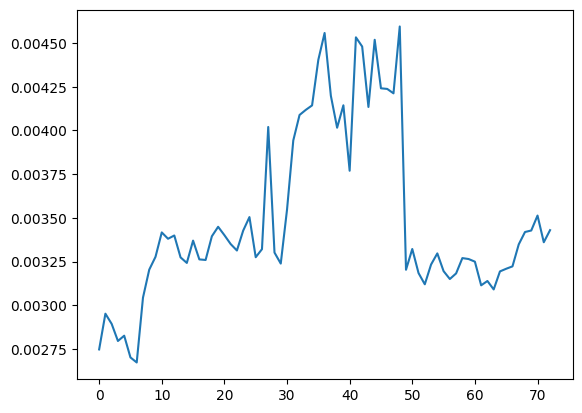

In [122]:
plt.plot(test_pred_rf)

In [123]:
selected_features

array(['vwap', 'MA_72_Volatility', '12_ma', 'volatility_40', '48_ma',
       'MA_48_Volatility', 'volatility_80', 'volatility_160', '24_ma',
       'volatility_20h', 'upper_band', 'obv_log_diff', 'MA_24_Volatility',
       'signal_line', 'MACDRV', 'ma', '72_ma', 'MA_18_Volatility',
       'EMARV', 'MA_15_Volatility', 'ATR', '6_ma', 'lower_band',
       'log_mean_1h', 'Diff_MA_48_Volatility', 'mfi', 'MA_72_Returns',
       'obv', '72_ma_log_diff', 'rsi', 'MA_24_Log_Returns', 'macd_line',
       'MA_12_Volatility', 'Diff_MA_72_Volatility', 'MA_72_Log_Returns',
       'MA_9_Volatility', 'MA_24_Returns', 'MA_15_Returns',
       'MA_15_Log_Returns', 'Diff_MA_12_Volatility', '24_ma_log_diff',
       'log_variance_1h', 'Diff_MA_24_Volatility', 'long_interval_vpin',
       'volatility_20', 'Diff_MA_9_Volatility', 'High',
       'Diff_MA_15_Volatility', 'Diff_MA_18_Volatility',
       'MA_6_Volatility'], dtype=object)

In [23]:
pd.DataFrame(test_pred_rf).to_csv('/Users/sonhyeongjin/Desktop/project/assend/2024 BDA 연합공모전_(Alpha and Omega)/(ASCENDxBDA) submission_0.csv')

## 데이터 분석

1. shuffle=True
2. 학습기간

모델의 성능을 확인하면서 특이한 점을 발견하였습니다.
가장 눈에 띈 것은 train_test_split에서 셔플을 했을때와 하지 않았을 때 입니다.

In [55]:
X, __, y, __ = train_test_split(final_X.iloc[-1000:-146], final_y.iloc[-1000:-146], test_size=0.2, random_state=42,shuffle=False)

# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# feature selection
feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
selected_features = feature_importance.head(50)['Feature'].values

X, __, y, __ = train_test_split(final_X.iloc[:-1000], final_y.iloc[:-1000], test_size=0.00001, random_state=42, shuffle=False)

X_train_selected = X[selected_features]
# 선택된 feature로 모델 학습
rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)

rf_model_selected.fit(X_train_selected,y)
test_pred_rf = rf_model_selected.predict(final_df[-146:-73][selected_features])
test_error_rf = mape(final_y.iloc[-146:-73], test_pred_rf)
print("Random Forest - shuffle_F_test_error: ", test_error_rf)

Random Forest - shuffle_F_test_error:  0.4949067983844423


In [56]:


X, __, y, __ = train_test_split(final_X.iloc[-1000:-146], final_y.iloc[-1000:-146], test_size=0.2, random_state=42,shuffle=True)

# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)

# feature selection
feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
selected_features = feature_importance.head(50)['Feature'].values
X, __, y, __ = train_test_split(final_X.iloc[:-1000], final_y.iloc[:-1000], test_size=0.00001, random_state=42, shuffle=True)
X_train_selected = X[selected_features]
# 선택된 feature로 모델 학습
rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
rf_model_selected.fit(X_train_selected,y)
test_pred_rf = rf_model_selected.predict(final_df[-146:-73][selected_features])
test_error_rf = mape(final_y.iloc[-146:-73], test_pred_rf)
print("Random Forest - shuffle_T_test_error: ", test_error_rf)

Random Forest - shuffle_T_test_error:  0.4070151227398905


셔플을 하였을때는 MAPE값이 0.4419209989833158인 반면에 셔플을 하지 않았을 경우 MAPE 값이 0.5239343575172084이 나왔습니다. 

변동성 데이터는 시계열이기에 셔플을 하지 않는것이 기존 방법이지만 현 테스크에서는 셔플을 한 것이 성능이 더 좋았습니다. 

위 상황이 운이 좋게 설정한 기간에만 맞는지 확인하기 위해 학습한 기간을 다르게 적용해보았습니다.

In [494]:
selected_features

array(['vwap', 'MA_72_Volatility', '12_ma', '24_ma', 'upper_band',
       'volatility_80', 'volatility_40', 'MA_48_Volatility',
       'log_mean_1h', 'MA_24_Volatility', 'signal_line', 'volatility_160',
       'ma', '48_ma', 'obv_log_diff', 'lower_band', '72_ma', '6_ma',
       'MA_15_Log_Returns', 'MACDRV', 'volatility_20h', 'EMARV',
       'MA_15_Returns', 'Diff_MA_9_Volatility', 'MA_18_Volatility',
       'MA_72_Log_Returns', 'MA_72_Returns', 'rsi', 'mfi',
       'MA_15_Volatility', 'Diff_MA_48_Volatility', 'ATR',
       '72_ma_log_diff', 'RSIRV', 'Diff_MA_12_Volatility',
       'MA_24_Returns', 'MA_24_Log_Returns', '24_ma_log_diff',
       'volatility_20', 'Diff_MA_24_Volatility', 'MA_12_Volatility',
       'MA_3_Volatility', 'MA_9_Volatility', 'High',
       'Diff_MA_72_Volatility', 'macd_line', 'MA_6_Volatility',
       'MA_48_Log_Returns', 'Diff_MA_15_Volatility', 'log_variance_1h'],
      dtype=object)

In [496]:
MAPE_list_F = []
for i in tqdm(range(1100,8073,200)):
       

    
    # X, __, y, __ = train_test_split(final_X.iloc[-1000:-146], final_y.iloc[-1000:-146], test_size=0.2, random_state=42,shuffle=True)

    # # Random Forest 모델 생성 및 학습
    # rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # rf_model.fit(X, y)

    # # feature selection
    # feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
    # feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # selected_features = feature_importance.head(50)['Feature'].values
    X, __, y, __ = train_test_split(final_X.iloc[-i:-1000], final_y.iloc[-i:-1000], test_size=0.2, random_state=42, shuffle=False)

    X_train_selected = X[selected_features]
    # 선택된 feature로 모델 학습
    rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
    rf_model_selected.fit(X_train_selected,y)
    test_pred_rf = rf_model_selected.predict(final_df[-146:][selected_features])
    test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)
    MAPE_list_F.append(test_error_rf)

100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


In [495]:
MAPE_list_T = []
for i in tqdm(range(1100,8073,200)):
       

    # X, __, y, __ = train_test_split(final_X.iloc[-i:-1000], final_y.iloc[-i:-1000], test_size=0.2, random_state=42,shuffle=True)

    # # Random Forest 모델 생성 및 학습
    # rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # rf_model.fit(X, y)

    # # feature selection
    # feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
    # feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # selected_features = feature_importance.head(50)['Feature'].values
    X, __, y, __ = train_test_split(final_X.iloc[-i:-1000], final_y.iloc[-i:-1000], test_size=0.2, random_state=42, shuffle=True)

    X_train_selected = X[selected_features]
    # 선택된 feature로 모델 학습
    rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
    rf_model_selected.fit(X_train_selected,y)
    test_pred_rf = rf_model_selected.predict(final_df[-146:][selected_features])
    test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)
    MAPE_list_T.append(test_error_rf)

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:27<00:00,  1.26it/s]


In [514]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error


# 데이터를 훈련 세트와 테스트 세트로 나눔
X, __, y, __ = train_test_split(final_X.iloc[-i:-1000], final_y.iloc[-i:-1000], test_size=0.2, random_state=42, shuffle=True)

# 선형 회귀 모델 생성
X_train_selected = X[selected_features]
    # 선택된 feature로 모델 학습
rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
rf_model_selected.fit(X_train_selected,y)
test_pred_rf = rf_model_selected.predict(final_df[-146:][selected_features])
# 교차 검증 수행
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
 # 5-fold cross-validation
cv_scores = cross_val_score(rf_model_selected, X, y, cv=5, scoring=mape_scorer)
cv_mape = -cv_scores.mean()  # 음수값을 양수로 변환
print("Cross-validation MAPE:", cv_mape)

Cross-validation MAPE: 0.17809551655727796


{'whiskers': [<matplotlib.lines.Line2D at 0x2c520f9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c520f580>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c520f730>],
 'medians': [<matplotlib.lines.Line2D at 0x2c520fdc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c523c0a0>],
 'means': []}

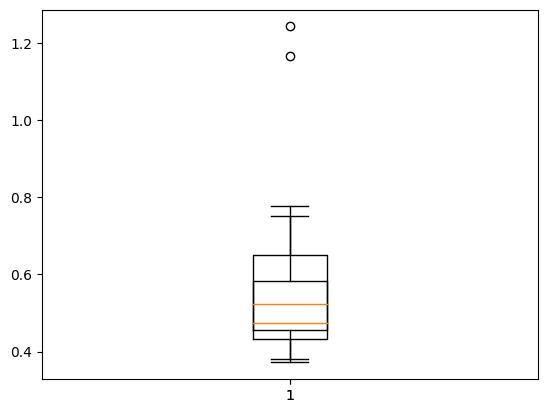

In [502]:
plt.boxplot(MAPE_list_F)
plt.boxplot(MAPE_list_T)

In [506]:
max_value = max(MAPE_list_F)

# 가장 큰 값 제외하고 새로운 리스트 생성
MAPE_list_F_new = [x for x in MAPE_list_F if x != max_value]
max_value = max(MAPE_list_T)

# 가장 큰 값 제외하고 새로운 리스트 생성
MAPE_list_T_new = [x for x in MAPE_list_T if x != max_value]

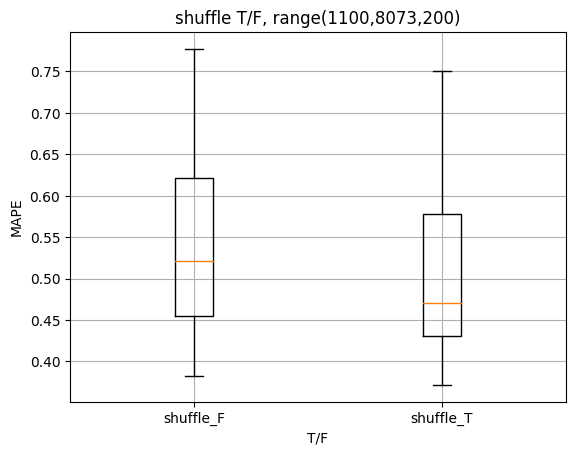

In [508]:
import matplotlib.pyplot as plt
import numpy as np



# 상자그림 플롯
plt.boxplot([MAPE_list_F_new, MAPE_list_T_new])

# 레이블 설정
plt.xticks([1, 2], ['shuffle_F', 'shuffle_T'])

# 그리드 추가
plt.grid(True)

# 제목 추가
plt.title('shuffle T/F, range(1100,8073,200)')

# 축 레이블 추가
plt.xlabel('T/F')
plt.ylabel('MAPE')

# 플롯 보여주기
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston


# 데이터를 훈련 세트와 테스트 세트로 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성

# 교차 검증 수행
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


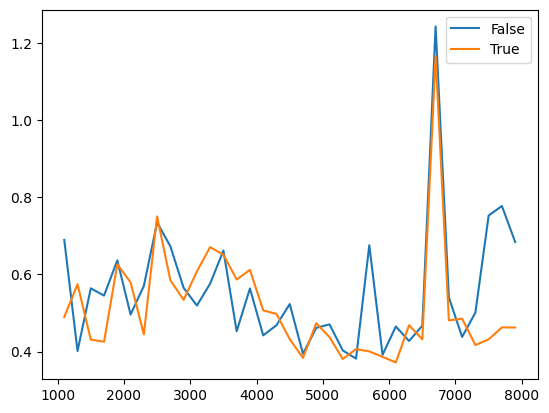

In [498]:
plt.plot(range(1100,8073,200),MAPE_list_F,label = 'False')
plt.plot(range(1100,8073,200),MAPE_list_T,label = 'True')
plt.legend()
plt.show()

위 플롯 상으로는 셔플 했을때와 하지 않았을 때 둘다 비슷한 성능을 내는 것 같았습니다. 즉 학습하는 데이터가 딱히 시계열성을 가지고있지 않다고 볼 수 있다고 생각했습니다..

물론 현재 사용하는 모델이 시계열 모델이  Random Forest이며 이 모델은 시계열을 학습하는 모델이 아닙니다.

하지만 위에서 새로 만든 feature들은 대부분 시계열 특성을 가지고 만든 column입니다. 그럼으로 어느정도 모델이 시계열성을 학습 할 수 있다고 생각하였지만 위 실험으로 데이터 자체가 시계열성을 띈다고 말하기 어려워 졌습니다. 

통상적으로 시계열 데이터가 아닌 데이터는 Test, Train split을 할때 test성능을 높이기 위해서 shuffle을 진행하였습니다. 하지만 시계열 데이터는 그렇지 못함으로 많은 제약이 생깁니다. 

위와 같은 실험으로 현재 task의 데이터가 시계열을 띈다고 보기 어려움으로 test성능을 높이기 위해 shuffle을 진행하였습니다. 

위 그래프에서 재미있는 점은 500구간에서 갑작이 MAPE가 상승하였다. 500구간쯤 년도가 바뀌었기 때문에 이는 한번 살펴볼만 하다고 생각하였습니다. 

### 구간 절단

500대에서 MAPE가 갑작이 상승하였기에 이를 확인하고자 데이터를 학습할때 최근 기간을 조절하면서 MAPE값을 확인해보았습니다.

In [205]:
erro_list_1 = []
pre_list = []
for i in tqdm(range(146,2073,100)):
    # X, __, y, __ = train_test_split(final_X.iloc[:-i], final_y.iloc[:-i], test_size=0.2, random_state=42,shuffle=True)

    # # Random Forest 모델 생성 및 학습
    # rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # rf_model.fit(X, y)

    # # feature selection
    # feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
    # feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # selected_features = feature_importance.head(50)['Feature'].values
    X, __, y, __ = train_test_split(final_X.iloc[:-i], final_y.iloc[:-i], test_size=0.00001, random_state=42, shuffle=False)
    X_train_selected = X[selected_features]
    # 선택된 feature로 모델 학습
    rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
    rf_model_selected.fit(X_train_selected,y)
    test_pred_rf = rf_model_selected.predict(ar_df[-146:][selected_features])
    test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)
    erro_list_1.append(test_error_rf)
    pre_list.append(test_pred_rf)


100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


In [422]:
erro_list_2 = []
pre_list = []
for i in tqdm(range(146,2073,100)):
    # X, __, y, __ = train_test_split(final_X.iloc[:-i], final_y.iloc[:-i], test_size=0.2, random_state=42,shuffle=True)

    # # Random Forest 모델 생성 및 학습
    # rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # rf_model.fit(X, y)

    # # feature selection
    # feature_importance = pd.DataFrame({'Feature': final_X.columns, 'Importance': rf_model.feature_importances_})
    # feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # selected_features = feature_importance.head(50)['Feature'].values
    X, __, y, __ = train_test_split(final_X.iloc[:-i], final_y.iloc[:-i], test_size=0.00001, random_state=42, shuffle=True)
    X_train_selected = X[selected_features]
    # 선택된 feature로 모델 학습
    rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
    rf_model_selected.fit(X_train_selected,y)
    test_pred_rf = rf_model_selected.predict(ar_df[-146:][selected_features])
    test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)
    erro_list_2.append(test_error_rf)
    pre_list.append(test_pred_rf)


100%|██████████| 19/19 [01:52<00:00,  5.93s/it]


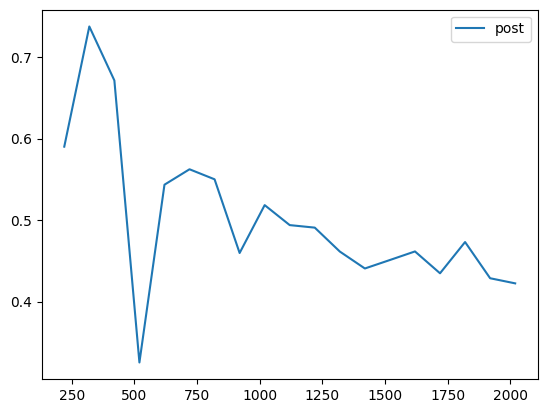

In [424]:
# plt.plot(range(146,2073,100),erro_list_1,label = 'pre')
plt.plot(range(220,2073,100),erro_list_2,label = 'post')
plt.legend()
plt.show()

위와 같이 예측시점과 가까운 데이터를 넣었을 때 MAPE가 급격하게 상승한 것을 볼 수 있습니다. 위 데이터를 노이즈라고 판단하고 학습할 때 제외하기로 하였습니다.

또한 500을 기점으로 급락하긴 하지만 향후 데이터를 학습하는데 위와 같은 현상이 좋지 못한 영향을 미칠 것 같아 1000일 전까지의 데이터를 학습하였습니다.

In [83]:
real_data= np.array([0.0042652 , 0.00427689, 0.00437102, 0.00435253, 0.0043372 ,
       0.00434457, 0.00435043, 0.00401338, 0.00397555, 0.00387397,
       0.00387026, 0.0038689 , 0.00380682, 0.0041059 , 0.00411661,
       0.00355798, 0.00375626, 0.00350609, 0.00327669, 0.00324509,
       0.00314015, 0.0032057 , 0.00309978, 0.00309435, 0.00306711,
       0.00307314, 0.00304272, 0.00312311, 0.00311137, 0.0031288 ,
       0.00312707, 0.00314246, 0.00312132, 0.00272254, 0.00273607,
       0.00430915, 0.0050792 , 0.00513436, 0.00524237, 0.00594709,
       0.0061074 , 0.00645611, 0.00650859, 0.00650899, 0.00653501,
       0.00655038, 0.0065591 , 0.00660611, 0.00660945, 0.00664263,
       0.00661048, 0.00653692, 0.00652464, 0.0065214 , 0.00653968,
       0.00580223, 0.00485824, 0.0049877 , 0.00501158, 0.00392919,
       0.00378063, 0.00230536, 0.00229735, 0.00203457, 0.0020637 ,
       0.00202315, 0.00201919, 0.00197643, 0.00201864, 0.00215428,
       0.00218866, 0.00219105, 0.00219979, 0.00232236, 0.00231472,
       0.00228192, 0.00234987, 0.00302608, 0.00315724, 0.003311  ,
       0.00332092, 0.00333222, 0.00333261, 0.00333143, 0.00344896,
       0.00347307, 0.00347189, 0.00355596, 0.0035307 , 0.0034534 ,
       0.00351664, 0.00367477, 0.00378813, 0.00384724, 0.00381217,
       0.00387596, 0.00396826, 0.00277579, 0.00292685, 0.00287616,
       0.00291778, 0.00289985, 0.00286366, 0.00286307, 0.00284644,
       0.00287729, 0.00304352, 0.00298389, 0.00300153, 0.0030842 ,
       0.00303871, 0.00286024, 0.00450824, 0.00523387, 0.00541152,
       0.00530903, 0.00526851, 0.00524613, 0.00519356, 0.005228  ,
       0.00528468, 0.0053166 , 0.00539607, 0.00541963, 0.00540216,
       0.00547267, 0.00547282, 0.00548509, 0.00545045, 0.00533285,
       0.00533228, 0.0053036 , 0.00403259, 0.00295877, 0.00280877,
       0.00294049, 0.00299818, 0.00298813, 0.00305905, 0.00303469,
       0.00298853, 0.00286934, 0.00250768, 0.0025878 , 0.00321021,
       0.00321021])

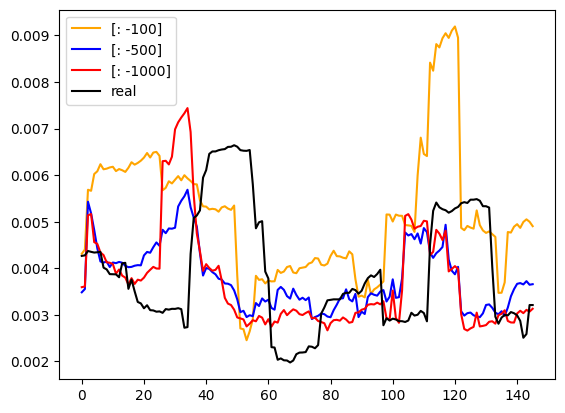

In [125]:
for index,i in enumerate(pre_list):
    if index == 0:   
        plt.plot(i,label = f"[: -{(index+1)*100}]",color = 'orange')
    if index == 4:
        plt.plot(i,label = f"[: -{(index+1)*100}]",color = 'blue')
    if index == 9:
        plt.plot(i,label = f"[: -{(index+1)*100}]",color = 'red')
    
plt.plot(real_data,label = 'real',color = 'black')
plt.legend()
plt.show()

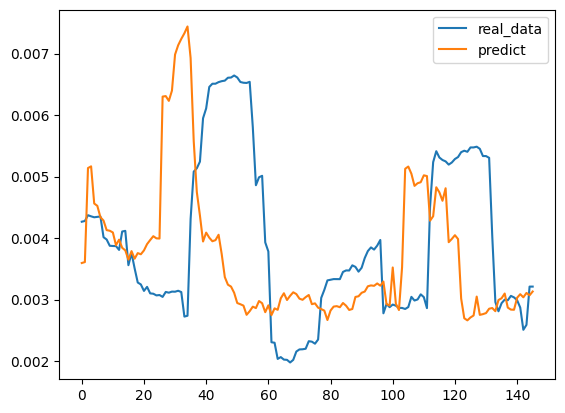

In [131]:
plt.plot(real_data,label= 'real_data')
plt.plot(pre_list[9],label = 'predict')
plt.legend()
plt.show()

In [324]:
selected_features[:20]

array(['vwap', 'MA_72_Volatility', '12_ma', '24_ma', 'upper_band',
       'volatility_80', 'volatility_40', 'MA_48_Volatility',
       'log_mean_1h', 'MA_24_Volatility', 'signal_line', 'volatility_160',
       'ma', '48_ma', 'obv_log_diff', 'lower_band', '72_ma', '6_ma',
       'MA_15_Log_Returns', 'MACDRV'], dtype=object)

In [414]:
start_index = 22
end_index = 40

# 중간 부분 제거
my_list = list(selected_features[:15]) + list(selected_features[15:50])

In [415]:
selec_list_end = []
X, __, y, __ = train_test_split(final_X.iloc[:-1000], final_y.iloc[:-1000], test_size=0.00001, random_state=42, shuffle=True)
X_train_selected = X[my_list]
# 선택된 feature로 모델 학습
rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
rf_model_selected.fit(X_train_selected,y)
test_pred_rf = rf_model_selected.predict(final_X[-146:][my_list])
test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)
selec_list_end.append(test_pred_rf)

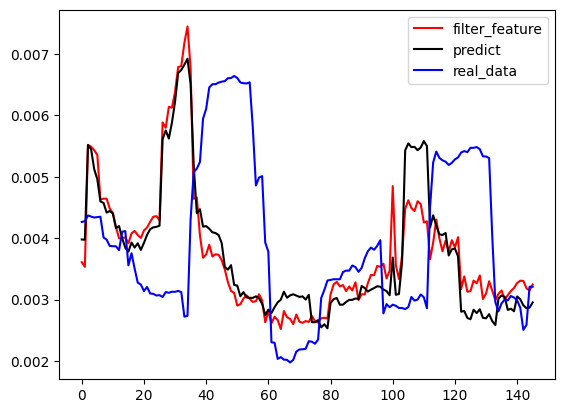

In [416]:
plt.plot(selec_list_end[0],label = 'filter_feature',color = 'red')
plt.plot(pre_list[9],label = 'predict',color = 'black')
plt.plot(real_data,label ='real_data',color = 'blue')
plt.legend()
plt.show()

In [471]:
selected_features =np.array(['vwap', 'MA_72_Volatility', '12_ma', '24_ma', 'upper_band',
       'volatility_80', 'volatility_40', 'MA_48_Volatility',
        'MA_24_Volatility', 'signal_line', 'volatility_160',
       'ma', '48_ma', 'obv_log_diff', 'lower_band', '72_ma', '6_ma',
       'MA_15_Log_Returns', 'MACDRV', 'volatility_20h', 'EMARV',
       'MA_15_Returns', 'Diff_MA_9_Volatility', 'MA_18_Volatility',
       'MA_72_Log_Returns', 'MA_72_Returns',
       'MA_15_Volatility', 'Diff_MA_48_Volatility', 'ATR',
       '72_ma_log_diff', 'RSIRV', 'Diff_MA_12_Volatility',
       'MA_24_Returns', 'MA_24_Log_Returns', '24_ma_log_diff',
       'volatility_20', 'Diff_MA_24_Volatility', 'MA_12_Volatility',
       'MA_3_Volatility', 'MA_9_Volatility', 'High',
       'Diff_MA_72_Volatility', 'macd_line', 'MA_6_Volatility',
       'MA_48_Log_Returns', 'Diff_MA_15_Volatility',
       'MA_48_Returns', '3_ma', 'obv', 'Diff_MA_18_Volatility',
       'volatility', 'MA_6_Log_Returns', 'vwap_log_diff', 'MA_3_Returns',
       '3_ma_log_diff', 'Close', 'Volatility', 'MA_18_Returns',
       'MA_12_Log_Returns', 'MA_9_Log_Returns', 'Std',
       'MA_18_Log_Returns', 'Skew', 'MA_3_Log_Returns',
       'long_interval_vpin', 'MA_12_Returns', '2+tick_sell_ratio', 'Open',
       '2tick_buy_ratio', 'Diff_MA_3_Volatility', 'MA_6_Returns', 'Low',
       'Diff_MA_6_Volatility', 'Volume', '2+tick_buy_ratio', 'num',
       '6_ma_log_diff', 'returns_5', 'wap', '48_ma_log_diff',
       'short_interval_vpin', 'TR', 'CRTDR', 'lower_band_log_diff',
       'midas', 'Volume_std', '12_ma_log_diff', 'Volume_skew',
       'Diff_MA_3_Returns', 'returns_4', 'High_log_diff',
       'Diff_MA_12_Returns', 'Diff_MA_9_Log_Returns', 'returns_2',
       'Diff_MA_48_Log_Returns', 'Diff_MA_15_Log_Returns'])

In [473]:
head_list_mape = []
head_list_vola = []
for i in range(1,47):
    X, __, y, __ = train_test_split(final_X.iloc[:-1000], final_y.iloc[:-1000], test_size=0.00001, random_state=42, shuffle=True)
    X_train_selected = X[selected_features[:i]]
    # 선택된 feature로 모델 학습
    rf_model_selected = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
    rf_model_selected.fit(X_train_selected,y)
    test_pred_rf = rf_model_selected.predict(final_X[-146:][selected_features[:i]])
    test_error_rf = mape(final_y.iloc[-146:], test_pred_rf)
    head_list_mape.append(test_error_rf)
    head_list_vola.append(test_pred_rf)

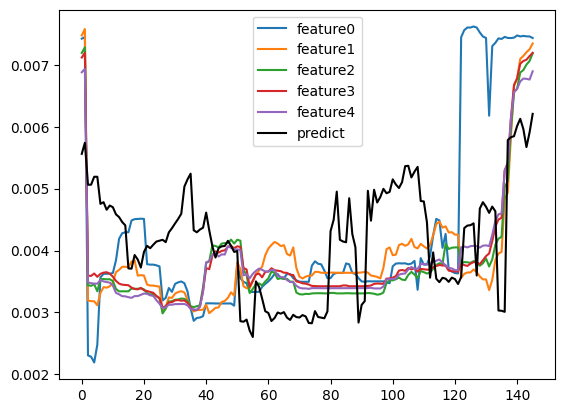

In [474]:
for i in range(5):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()



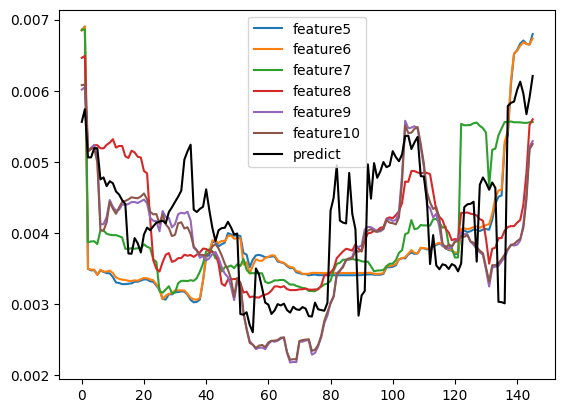

In [475]:
for i in range(5,11):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

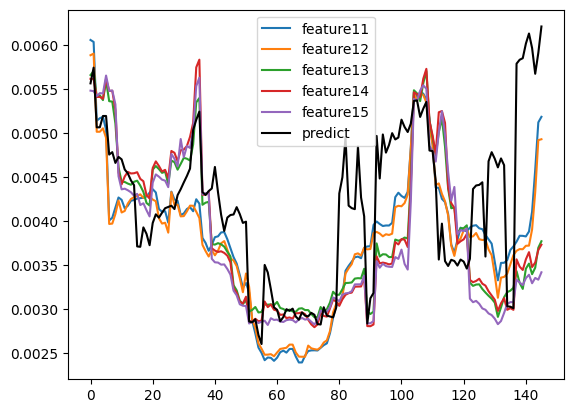

In [476]:
for i in range(11,16):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

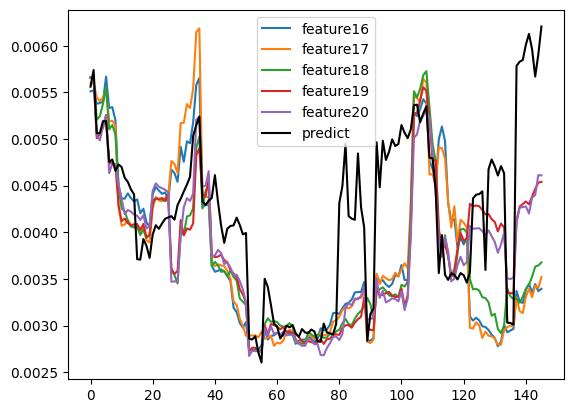

In [477]:
for i in range(16,21):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

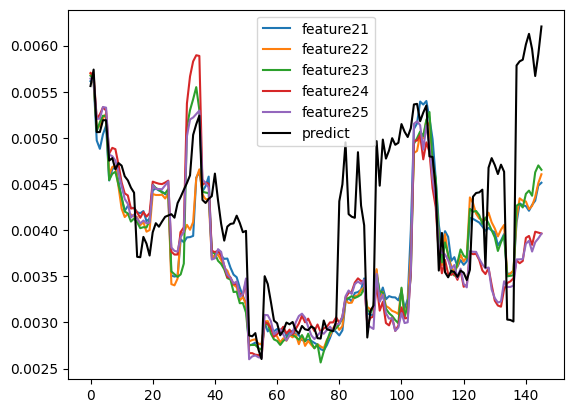

In [478]:
for i in range(21,26):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

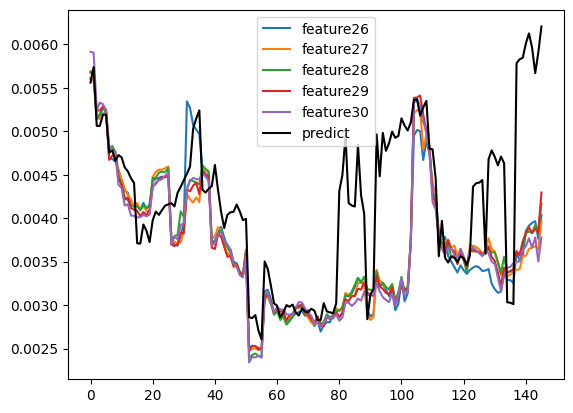

In [479]:
for i in range(26,31):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

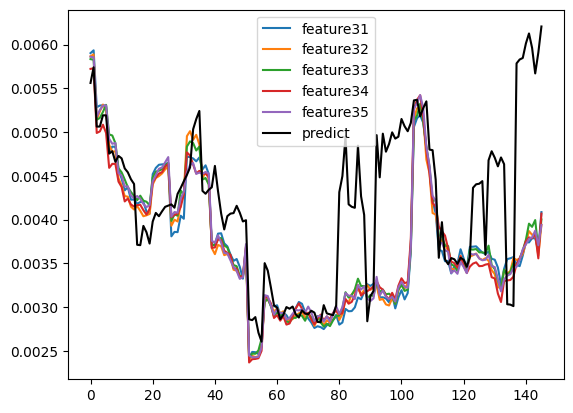

In [480]:
for i in range(31,36):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

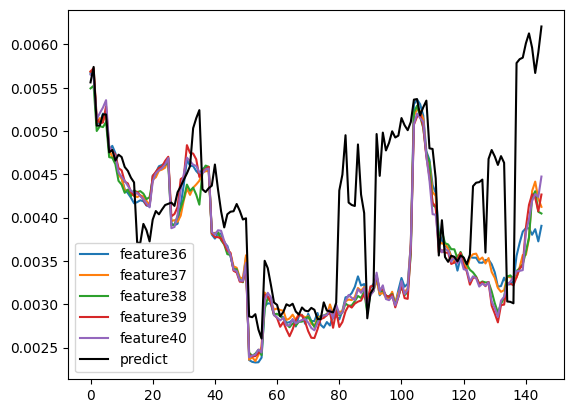

In [481]:
for i in range(36,41):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

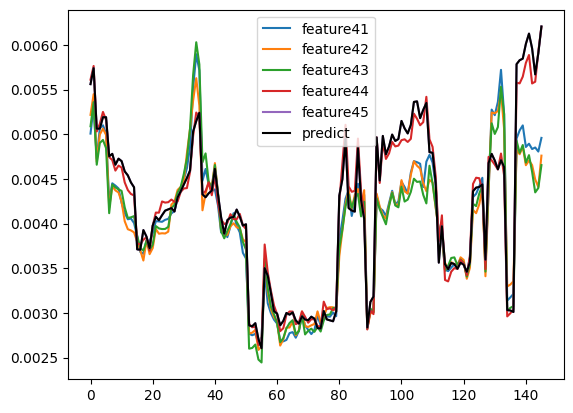

In [483]:
for i in range(41,46):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(head_list_vola[45],label = 'predict',color = 'black')
plt.legend()
plt.show()

IndexError: list index out of range

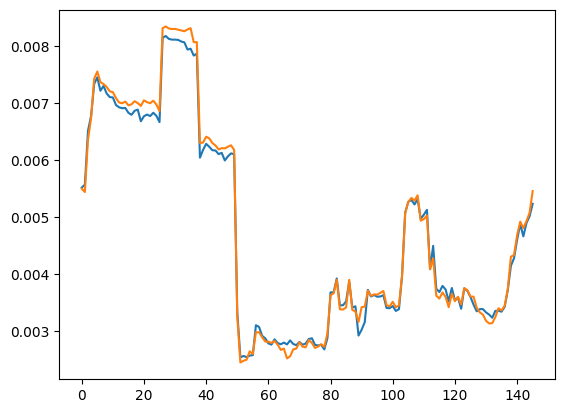

In [419]:
selected_features

array(['vwap', 'MA_72_Volatility', '12_ma', '24_ma', 'upper_band',
       'volatility_80', 'volatility_40', 'MA_48_Volatility',
       'log_mean_1h', 'MA_24_Volatility', 'signal_line', 'volatility_160',
       'ma', '48_ma', 'obv_log_diff', 'lower_band', '72_ma', '6_ma',
       'MA_15_Log_Returns', 'MACDRV', 'volatility_20h', 'EMARV',
       'MA_15_Returns', 'Diff_MA_9_Volatility', 'MA_18_Volatility',
       'MA_72_Log_Returns', 'MA_72_Returns', 'rsi', 'mfi',
       'MA_15_Volatility', 'Diff_MA_48_Volatility', 'ATR',
       '72_ma_log_diff', 'RSIRV', 'Diff_MA_12_Volatility',
       'MA_24_Returns', 'MA_24_Log_Returns', '24_ma_log_diff',
       'volatility_20', 'Diff_MA_24_Volatility', 'MA_12_Volatility',
       'MA_3_Volatility', 'MA_9_Volatility', 'High',
       'Diff_MA_72_Volatility', 'macd_line', 'MA_6_Volatility',
       'MA_48_Log_Returns', 'Diff_MA_15_Volatility', 'log_variance_1h',
       'MA_48_Returns', '3_ma', 'obv', 'Diff_MA_18_Volatility',
       'volatility', 'MA_6_Log_Re

In [168]:
feature_importance.head(50)

,Feature,Importance
15,vwap,0.275320
98,MA_72_Volatility,0.159581
104,12_ma,0.045953
128,volatility_40,0.043496
106,48_ma,0.040066
92,MA_48_Volatility,0.029963
129,volatility_80,0.028999
130,volatility_160,0.022422
105,24_ma,0.022301
34,volatility_20h,0.019931


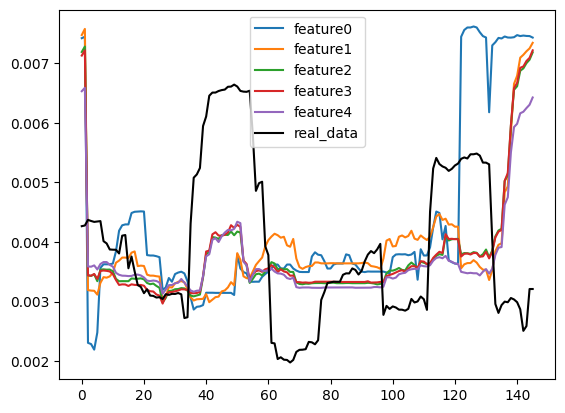

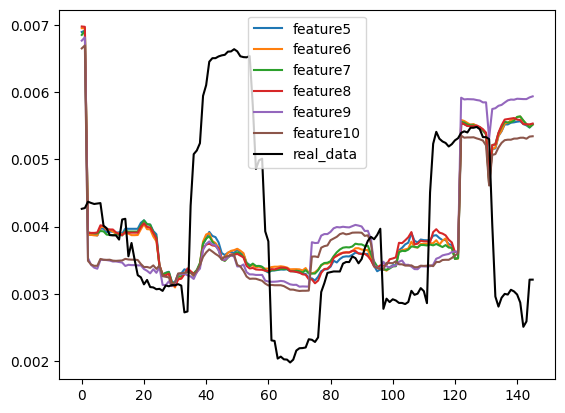

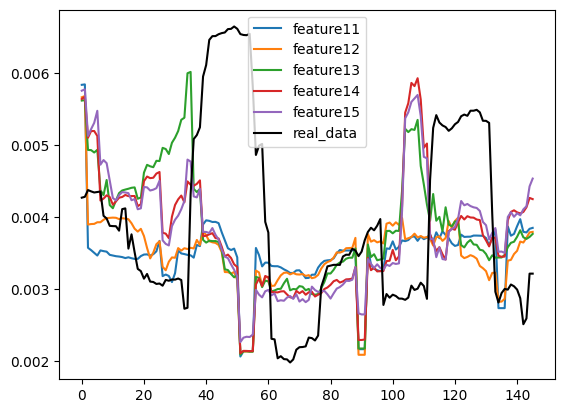

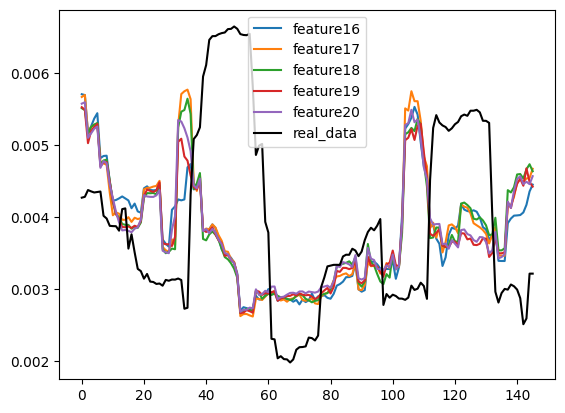

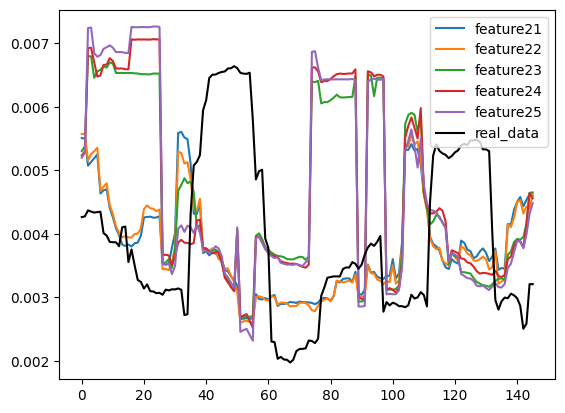

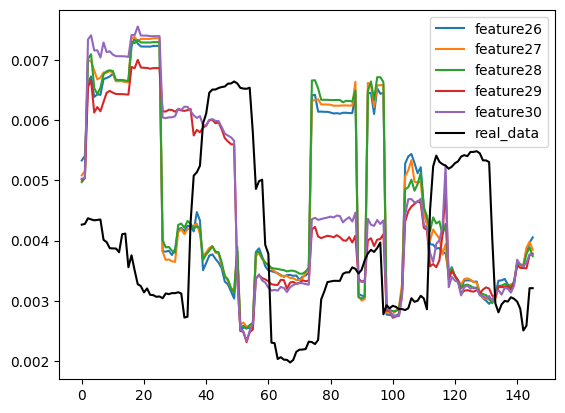

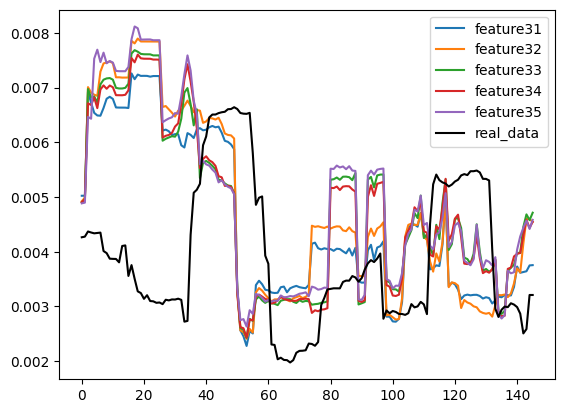

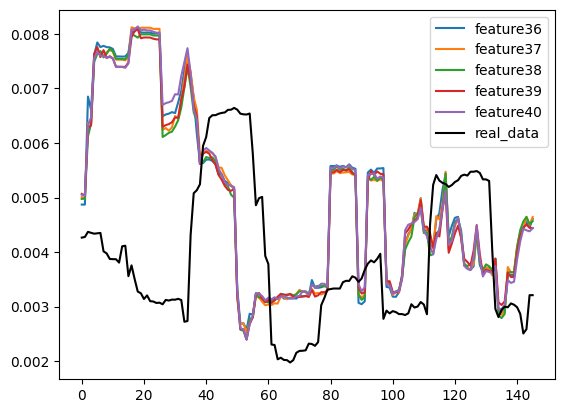

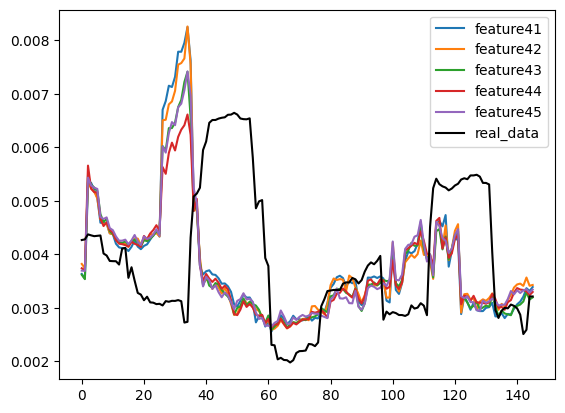

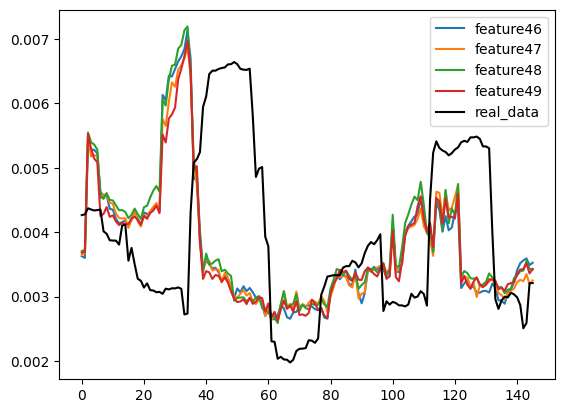

In [171]:
for i in range(5):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()


for i in range(5,11):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(11,16):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(16,21):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(21,26):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(26,31):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(31,36):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(36,41):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(41,46):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()
for i in range(46,50):
    plt.plot(head_list_vola[i],label = f'feature{i}')
plt.plot(real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()

In [182]:
x1 = range(146)
x2 = range(30,176)

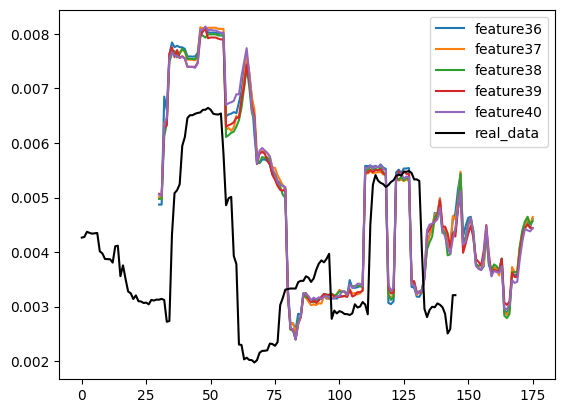

In [183]:
for i in range(36,41):
    plt.plot(x2,head_list_vola[i],label = f'feature{i}')
plt.plot(x1,real_data,label = 'real_data',color = 'black')
plt.legend()
plt.show()

In [174]:
len(head_list_vola[1])

146

In [194]:
feature_importance[22:41]['Feature'].values

array(['lower_band', 'log_mean_1h', 'Diff_MA_48_Volatility', 'mfi',
       'MA_72_Returns', 'obv', '72_ma_log_diff', 'rsi',
       'MA_24_Log_Returns', 'macd_line', 'MA_12_Volatility',
       'Diff_MA_72_Volatility', 'MA_72_Log_Returns', 'MA_9_Volatility',
       'MA_24_Returns', 'MA_15_Returns', 'MA_15_Log_Returns',
       'Diff_MA_12_Volatility', '24_ma_log_diff'], dtype=object)

In [188]:
feature_importance[41:51]['Feature'].values

array(['log_variance_1h', 'Diff_MA_24_Volatility', 'long_interval_vpin',
       'volatility_20', 'Diff_MA_9_Volatility', 'High',
       'Diff_MA_15_Volatility', 'Diff_MA_18_Volatility',
       'MA_6_Volatility', '3_ma'], dtype=object)

In [195]:
feature_importance[:22]['Feature'].values

array(['vwap', 'MA_72_Volatility', '12_ma', 'volatility_40', '48_ma',
       'MA_48_Volatility', 'volatility_80', 'volatility_160', '24_ma',
       'volatility_20h', 'upper_band', 'obv_log_diff', 'MA_24_Volatility',
       'signal_line', 'MACDRV', 'ma', '72_ma', 'MA_18_Volatility',
       'EMARV', 'MA_15_Volatility', 'ATR', '6_ma'], dtype=object)

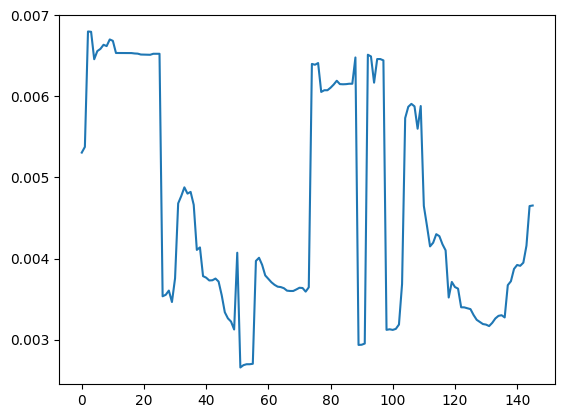

In [196]:
plt.plot(head_list_vola[23],label = f'feature{22}')

In [197]:
feature_importance[22:24]['Feature'].values


array(['lower_band', 'log_mean_1h'], dtype=object)

In [198]:
feature_importance[40:42]['Feature'].values

array(['24_ma_log_diff', 'log_variance_1h'], dtype=object)

In [ ]:
feature_TA =['Vwap, obv_log_diff, MACDRV, EMARV, ATR, upper_band, signal_line, ma,lower_band, mfi, obv, rsi, macd_line,long_interval_vpin, High


]